In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time
from cvxopt import matrix, solvers
from numpy import array, eye, hstack, ones, vstack, zeros
from tqdm import tqdm


class gameworld():

    def __init__(self, playerA, playerB):
        self.playerA = playerA
        self.playerB = playerB
        self.rows = 2
        self.columns = 4
        self.goal_stateA = [0, 4]
        self.goal_stateB = [3, 7]
        self.ball = np.random.randint(2)
        self.ball_pos = playerA.pos

        print("Gameworld Initlialized...")

    def new_game(self, random_start = True):
        # print("NEW GAME")
        starting_positions = [1, 2, 5, 6]
        random_int = np.random.choice(len(starting_positions), 2, replace=False)


        if random_start:
            # Random Player Position
            playerA.pos = starting_positions[random_int[0]]
            playerB.pos = starting_positions[random_int[1]]

            # Ball starts randomly in one player's possesion
            if np.random.randint(2) == 0:
                self.ball = playerA.ball
                self.ball_pos = playerA.pos
            else:
                self.ball = playerB.ball
                self.ball_pos = playerB.pos

        else:
            #Start in Selected State
            playerA.pos = 2
            playerB.pos = 1
            self.ball = playerB.ball
            self.ball_pos = playerB.pos


        # print("New game. Player A: {} Player B: {} Ball: {}".format(playerA.pos, playerB.pos, self.ball_pos))
        # print("Player {} has the ball".format(self.ball))

    def move_player(self, player, action):

        # print("Player {} location {}".format(player.name, player.pos))
        # Move North
        if action == 0 and player.pos > 3:
            player_loc = player.pos - 4
        # Move East
        elif action == 1 and player.pos not in self.goal_stateB:
            player_loc = player.pos + 1
        # Move South
        elif action == 2 and player.pos < 4:
            player_loc = player.pos + 4
        # Move West
        elif action == 3 and player.pos not in self.goal_stateA:
            player_loc = player.pos - 1
        # Stick
        else:
            player_loc = player.pos

        # print("{} : New Location: {} BALL: {}".format(player.name, player_loc, self.ball +1))

        return player_loc

    def actions(self, player1, player2, action1, action2):

        temp_loc1 = self.move_player(player1, action1)
        temp_loc2 = self.move_player(player2, action2)

        # Player 1 moves first every time
        if temp_loc1 != player2.pos:
            # Move to empty spot
            player1.pos = temp_loc1
        else:
            # Transfer Ball if location is already occupied
            self.ball = player2.ball

        if temp_loc2 != player1.pos:
            player2.pos = temp_loc2
        else:
            self.ball = player1.ball

        #Move Ball with player
        if self.ball:
            self.ball_pos = playerA.pos
        else:
            self.ball_pos = playerB.pos

    def next_step(self, actionA, actionB):

        playerA = self.playerA
        playerB = self.playerB

        # First Mover chosen randomly
        if np.random.randint(2) == 0:
            self.actions(playerA, playerB, actionA, actionB)
        else:
            self.actions(playerB, playerA, actionB, actionA)

        # Goal Scored, End Game
        if self.ball_pos in self.goal_stateA:
            rewardA = 100
            rewardB = -100
            done = 1
            # print("Game Over, Ball in A Goal")
        elif self.ball_pos in self.goal_stateB:
            rewardA = -100
            rewardB = 100
            done = 1
            # print("Game Over, Ball in B Goal")
        else:
            rewardA = 0
            rewardB = 0
            done = 0

        return self.state(), rewardA, rewardB, done


    def state(self):
        return [playerA.pos, playerB.pos, game.ball]


class player():

    def __init__(self, name="PlayerX", ball = None):
        self.name = name
        self.score = 0
        self.pos = 0
        self.ball = ball
        print("Player {} Created".format(name))

    def has_ball(self):
        return self.ball


def graph_error(error_list, iter_list, name="Q Learning", linewidth = 1):

    plt.plot(iter_list, error_list, linewidth = linewidth)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.title(name)
    plt.xlabel('Iteration')
    plt.ylabel('Q Value Difference')
    plt.show()
    plt.gcf().clear()


def q_algo(game, playerA, playerB):

    iterations = 10 ** 6
    epsilon = 0.9
    epsilon_min = 0.01
    start_time = time.time()
    epsilon_decay = (epsilon - epsilon_min) / iterations
    alpha_start = 0.5
    alpha = 1.0
    alpha_min = 0.001
    alpha_decay = (alpha - alpha_min) / iterations
    gamma = 0.9

    width = 8
    height = 8
    depth = 2
    actions = 5
    Qa = np.zeros([height, width, depth, actions])
    Qb = np.zeros([height, width, depth, actions])

    game.new_game()
    done = 0

    error_list = []
    iter_list = []

    for i in range(iterations):

        if done == 1:
            game.new_game()

        a = playerA.pos
        b = playerB.pos
        ball = game.ball

        prev_q_val = Qa[2, 1, 1, 2]

        # Epsilon Greedy Search
        if epsilon > np.random.random():
            actionA = np.random.choice(actions)
            actionB = np.random.choice(actions)
        else:
            actionA = np.argmax(Qa[a, b, ball])
            # actionB = np.argmax(Qb[a, b, ball])
            actionB = np.random.choice(actions)


        nstate, rewardA, rewardB, done = game.next_step(actionA=actionA, actionB=actionB)
        na, nb, nball = nstate


        Qa[a, b, ball, actionA] = (1 - alpha) * Q[a, b, ball, actionA] + \
                                  alpha * ((1 - gamma) * rewardA + gamma * np.max(Qa[na, nb, nball]))

        # Qb[a, b, ball, actionB] = (1 - alpha) * Qb[a, b, ball, actionB] + \
        #                           alpha * ((1 - gamma) * rewardB + gamma * np.max(Qb[na, nb, nball]))


        if [a, b, ball, actionA, actionB] == [2, 1, 1, 2, 4]:
            error_list.append(abs(Qa[2, 1, 1, 2] - prev_q_val))
            iter_list.append(i)
            print("Iteration: ", i, alpha)


        # print("Gamma {} Alpha {} ".format(gamma, alpha))
        # epsilon -= epsilon_decay
        alpha -= alpha_decay
        # alpha *= np.e ** (-np.log(500.0) / 10 ** 6)

    print("Total Time:", time.time() - start_time)

    # graph error_list
    graph_error(error_list, iter_list, name="Q-Learner", linewidth=0.5)


def friend_q(game, playerA, playerB):

    start_time = time.time()
    iterations = 10 ** 6
    epsilon = 0.2
    epsilon_min = 0.01
    epsilon_decay = (epsilon - epsilon_min) / iterations
    alpha = 0.5   #TODO change to 1/n(s,a)
    alpha_min = 0.001
    alpha_decay = (alpha - alpha_min) / 10 ** 6
    gamma = 0.9


    width = 8
    height = 8
    depth = 2
    actions = 5
    Q = np.random.random([height, width, depth, actions, actions])
    # Q = np.zeros([height, width, depth, actions, actions])

    game.new_game()
    done = 0

    error_list = []
    iter_list = []

    for i in range(iterations):

        if done == 1:
            game.new_game()
            done = 0

        a = playerA.pos
        b = playerB.pos
        ball = game.ball

        prev_q_val = Q[2, 1, 1, 2, 4]

        actionA = np.random.randint(5)
        actionB = np.random.randint(5)

        nstate, rewardA, rewardB, done = game.next_step(actionA=actionA, actionB=actionB)
        na, nb, nball = nstate


        Q[a, b, ball, actionA, actionB] = (1 - alpha) * Q[a, b, ball, actionA, actionB] + \
                    alpha * ((1 - gamma) * rewardA + gamma * np.max(Q[na, nb, nball]))

        if [a, b, ball, actionA, actionB] == [2, 1, 1, 2, 4]:
            error_list.append(abs(Q[2, 1, 1, 2, 4] - prev_q_val))
            iter_list.append(i)
            print("Iteration: ", i)

        # print("Gamma {} Alpha {} ".format(gamma, alpha))
        epsilon -= epsilon_decay
        alpha *= np.e ** (-np.log(200.0) / 10 ** 6)

    print("Total Time:", time.time() - start_time)

    # graph error_list
    graph_error(error_list, iter_list, name="Friend Q Learning")



def solve_maximin(q):

    glpksolver = 'glpk'
    solvers.options['glpk'] = {'msg_lev': 'GLP_MSG_OFF'}  # cvxopt 1.1.8
    solvers.options['msg_lev'] = 'GLP_MSG_OFF'  # cvxopt 1.1.7
    solvers.options['LPX_K_MSGLEV'] = 0  # previous versions

    M = matrix(q).trans()
    n = M.size[1]


    A = hstack((ones((M.size[0], 1)), M))
    #Constraint: All P > 0
    eye_matrix = hstack((zeros((n, 1)), -eye(n)))

    A = vstack((A, eye_matrix))
    # Constraint: Sum(P) == 1
    A = matrix(vstack((A, hstack((0,ones(n))), hstack((0,-ones(n))))))

    #Create b Matrix
    b = matrix(hstack((zeros(A.size[0] - 2), [1, -1])))

    #Create C Matrix
    c = matrix(hstack(([-1], zeros(n))))

    sol = solvers.lp(c,A,b, solver=glpksolver)

    #print(sol["x"])
    return sol['primal objective']




def foe_q(game, playerA, playerB):

    iterations = 10 ** 6
    alpha = 0.9
    alpha_min = 0.001
    alpha_decay = (alpha - alpha_min) / 10 ** 6
    gamma = 0.9
    actions = np.arange(5)
    start_time = time.time()
    width = 8
    height = 8
    depth = 2
    actions = 5
    # Q = np.random.random([height, width, depth, actions, actions]) * 10
    Q = np.zeros([height, width, depth, actions, actions])

    game.new_game()
    done = 0

    error_list = []
    iter_list = []

    for i in tqdm(range(iterations)):
        # playerA.pos, playerB.pos, game.ball = a, b, ball


        if done == 1:
            game.new_game()
            done = 0

        a = playerA.pos
        b = playerB.pos
        ball = game.ball

        prev_q_val = Q[2, 1, 1, 2, 4]

        current_Q = Q[playerA.pos, playerB.pos, game.ball]
        actionA = np.random.choice(actions)
        actionB = np.random.choice(actions)

        #Find Maximin solution, Player B is opponent, Prime Objective is game value

        nstate, rewardA, rewardB, done = game.next_step(actionA=actionA, actionB=actionB)
        na, nb, nball = nstate
        next_Q = Q[na, nb, nball]

        prime_objective = solve_maximin(next_Q)

        Q[a, b, ball, actionA, actionB] = (1 - alpha) * Q[a, b, ball, actionA, actionB] + \
                    alpha * ((1 - gamma) * rewardA + gamma * prime_objective)



        #Update the value only if it changed during the iteration

        if [a, b, ball, actionA, actionB] == [2, 1, 1, 2, 4]:
            error_list.append(abs(Q[2, 1, 1, 2, 4] - prev_q_val))
            iter_list.append(i)
            #print("Iteration: ", i)

        # print("Gamma {} Alpha {} ".format(gamma, alpha))
        alpha *= np.e ** (-np.log(500.0) / 10 ** 6)

    print(Q[2, 1, 1])
    print("Total Time:", time.time()-start_time)

    #graph error_list
    graph_error(error_list, iter_list, name="Foe Q Learning")


def solve_ceq(q1, q2):

    glpksolver = 'glpk'
    solvers.options['glpk'] = {'msg_lev': 'GLP_MSG_OFF'}  # cvxopt 1.1.8
    solvers.options['msg_lev'] = 'GLP_MSG_OFF'  # cvxopt 1.1.7
    solvers.options['LPX_K_MSGLEV'] = 0  # previous versions

    M = matrix(q1).trans()
    n = M.size[1]

    A = np.zeros((2 * n * (n - 1), (n * n)))
    q1 = np.array(q1)
    q2 = np.array(q2) #TODO Possibly transpose? Code might already do this
    row = 0

    #Create system of equations for Correlated Q-Learning
    for i in range(n):
        for j in range(n):
            if i != j:
                A[row, i * n:(i + 1) * n] = q1[i] - q1[j]
                A[row + n * (n - 1), i:(n * n):n] = q2[:, i] - q2[:, j]
                row += 1

    A = matrix(A)
    # print(A.size[0])

    A = hstack((ones((A.size[0], 1)), A))
    #Constraint: All P > 0
    eye_matrix = hstack((zeros((n*n, 1)), -eye(n*n)))

    A = vstack((A, eye_matrix))
    # Constraint: Sum(P) == 1
    A = matrix(vstack((A, hstack((0,ones(n*n))), hstack((0,-ones(n*n))))))

    #Create b Matrix
    # print("A rows", A.size[0])
    # print(A)
    b = matrix(hstack((zeros(A.size[0] - 2), [1, -1])))

    # print("B", b)
    #Create C Matrix by flattening out collective sums at each a1,a2 location
    c = matrix(hstack(([-1.], -(q1+q2).flatten())))
    # print("C", c)
    sol = solvers.lp(c,A,b, solver=glpksolver)


    #Calculate Correlated Equilibrium
    if sol['x'] is None:
        return 0, 0
    dist = sol['x'][1:]
    q1_flat = q1.flatten()
    q2_flat = q2.transpose().flatten()

    #Calculated Expected return of individual players
    q1_exp_return = np.matmul(q1_flat, dist)[0]
    q2_exp_return = np.matmul(q2_flat, dist)[0]
    # print("EXPECTED GAME VALUE : {} {}".format(q1_exp_return, q2_exp_return))

    return q1_exp_return, q2_exp_return


def ce_q(game, playerA, playerB):

    iterations =  10 ** 6
    alpha = 0.9
    alpha_min = 0.001
    alpha_decay = (alpha - alpha_min) / 10 ** 6
    gamma = 0.9
    start_time = time.time()
    width = 8
    height = 8
    depth = 2
    actions = 5

    # Initialize Q Tables
    Qa = np.zeros([height, width, depth, actions, actions])
    Qb = np.zeros([height, width, depth, actions, actions])

    game.new_game()
    done = 0

    error_list = []
    iter_list = []

    for i in range(iterations):

        if done == 1:
            game.new_game()
            done = 0

        a = playerA.pos
        b = playerB.pos
        ball = game.ball

        prev_q_val = Qa[2, 1, 1, 2, 4]

        #Pick Random Actions for Both Players
        actionA = np.random.choice(actions)
        actionB = np.random.choice(actions)

        Qa_state = Qa[playerA.pos, playerB.pos, game.ball]
        Qb_state = Qb[playerA.pos, playerB.pos, game.ball]
        # Qa_state = Qa[na, nb, nball]
        # Qb_state = Qb[na, nb, nball]


        #Find CE solution

        nstate, rewardA, rewardB, done = game.next_step(actionA=actionA, actionB=actionB)
        na, nb, nball = nstate



        #Solve Correlated Equilibirum
        r_exp_A, r_exp_B = solve_ceq(Qa_state, Qb_state)

        Qa[a, b, ball, actionA, actionB] = (1 - alpha) * Qa[a, b, ball, actionA, actionB] + \
                    alpha * ((1 - gamma) * rewardA + gamma * r_exp_A)

        Qb[a, b, ball, actionA, actionB] = (1 - alpha) * Qb[a, b, ball, actionA, actionB] + \
                    alpha * ((1 - gamma) * rewardB + gamma * r_exp_B)


        #Update the value only if it changed during the iteration

        if [a, b, ball, actionA, actionB] == [2, 1, 1, 2, 4]:
            error_list.append(abs(Qa[2, 1, 1, 2, 4] - prev_q_val))
            iter_list.append(i)
            print("Iteration: ", i)


        # print("Gamma {} Alpha {} ".format(gamma, alpha))
        alpha *= np.e ** (-np.log(500.0) / 10 ** 6)
        # alpha -= alpha_decay

    graph_error(error_list, iter_list, name="Correlated Equilibirum Q Learning")

    print(Qa[2, 1, 1])
    print("Total Time:", time.time()-start_time)

  0%|          | 480/1000000 [00:00<03:28, 4795.95it/s]

Player A Created
Player B Created
Gameworld Initlialized...


100%|██████████| 1000000/1000000 [03:51<00:00, 4312.49it/s]


[[ -0.76227844   1.32714257  -9.          -9.          -0.76478628]
 [-10.          -0.70014322 -10.         -10.         -10.        ]
 [ -9.           3.92438681  -1.60595828  -9.          -9.        ]
 [ -0.77169211   0.2076198   -3.70481075  -2.40546587  -0.77033499]
 [ -0.76336327   1.33110629  -9.          -9.          -0.76322556]]
Total Time: 231.8860924243927


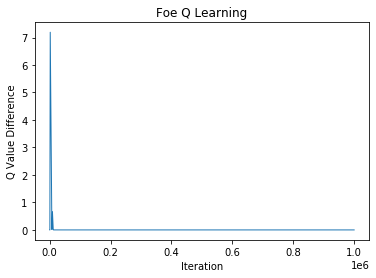

<Figure size 432x288 with 0 Axes>

In [12]:
playerA = player(name="A", ball = 0)
playerB = player(name="B", ball = 1)

game = gameworld(playerA, playerB)
#q_algo(game, playerA, playerB)
#friend_q(game, playerA, playerB)
foe_q(game, playerA, playerB)
# ce_q(game, playerA, playerB)

  0%|          | 467/1000000 [00:00<03:34, 4665.11it/s]

Player A Created
Player B Created
Gameworld Initlialized...


100%|██████████| 1000000/1000000 [03:44<00:00, 4452.28it/s]


[[-45.28776791 -45.26984734 -45.27254816 -45.28196452 -45.26505634]
 [-55.27173439 -50.36094547 -55.26943627 -55.29206286 -55.29120738]
 [-45.28082624 -45.26712774 -45.27733765 -45.27742774 -45.27034463]
 [-45.28245144 -45.2858605  -45.28836503 -45.25977189 -45.27442286]
 [-45.26640895 -45.28289319 -45.28552714 -45.27678062 -45.26443897]]
Total Time: 224.60663032531738


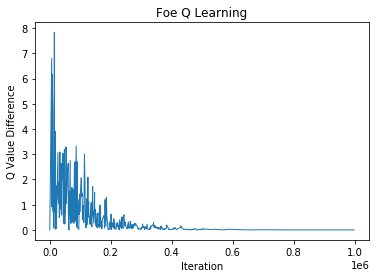

<Figure size 432x288 with 0 Axes>

In [4]:
playerA = player(name="A", ball = 0)
playerB = player(name="B", ball = 1)

game = gameworld(playerA, playerB)
#q_algo(game, playerA, playerB)
#friend_q(game, playerA, playerB)
foe_q(game, playerA, playerB)
# ce_q(game, playerA, playerB)

In [8]:
q = np.array([[-45.28776791 -45.26984734 -45.27254816 -45.28196452 -45.26505634],
 [-55.27173439 -50.36094547 -55.26943627 -55.29206286 -55.29120738],
 [-45.28082624 -45.26712774 -45.27733765 -45.27742774 -45.27034463],
 [-45.28245144 -45.2858605  -45.28836503 -45.25977189 -45.27442286],
 [-45.26640895 -45.28289319 -45.28552714 -45.27678062 -45.26443897]])
solve_maximin(q)

[ 2.71e+02]
[ 0.00e+00]
[ 1.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]



-271.48538637